# Validation Testing
The purpose of this notebook is to test the validation scores of the best found solutions at the end of the GA.

In [1]:
from figures_markdown_snippets import show_data_instructions

show_data_instructions()


To generate data, run:
- for sklearn
    ```bash
sbatch generate_sklearn_data.sb -n 10 -p 10
    ```
- for dhahri
    ```bash
sbatch generate_dhahri_data.sb -n 20 -p 100 -t 30
    ```
These commands generate files for running genetic search using 10 generations and population size of 10
for the sklearn tutorial and 20 generations with population size of 100
for the Breast Cancer Wisconsin (Diagnostic) Dataset respectively.

The `-n`, `-p`, `-t` flags control number of generations, population sizes, 
and number of trials respectively.

The data generated tracks the top 10 individuals and the population by
each generation and is stored in the corresponding output 
(i.e. the slurm_\[id\].out file).

To extract this data to a csv file, run:
- for the top 10 individuals:
    ```bash
grep "# GEN HOF_index" slurm_[id].out | cut -d '|' -f2 > "filename_1.csv"
    ```
- for the population:
    ```bash
grep "# GEN population_index" slurm_[id].out | cut -d '|' -f2 > "filename_2.csv"
    ```


In [2]:
# Path hack so that we can import see library.
import sys, os

sys.path.insert(0, os.path.abspath(".."))

In [3]:
# Set data files path names
hof_filepath = f"../0727_dhahri_simple_data/dhahri_2019_hof_20_100.csv"
population_filepath = f"../0727_dhahri_simple_data/dhahri_2019_population_20_100.csv"

In [4]:
# Helper functions

def extract_hof_population(
    hof_filepath,
    num_gen=100,
    pop_size=100,
    num_trials=30,
    hof_size=10,
):
    import pandas as pd

    hof_df = pd.read_csv(hof_filepath, header=None, delimiter=";")
    return hof_df


def create_hof_at_gen(hof_filepath, num_gen, pop_size, num_trials, hof_size, at_gen=0):
    import ast

    hof_df = extract_hof_population(
        hof_filepath, num_gen, pop_size, num_trials, hof_size
    )

    hof_list = hof_df[hof_df[0] == at_gen].to_numpy()
    hof_containers = list(map(ast.literal_eval, hof_list[:, 3]))
    return hof_containers, hof_list

def create_learning_curve(training_set, validation_set, containers):
    # learning curve
    from see.classifiers import Classifier
    import numpy as np

    train_sizes = np.linspace(30, len(training_set.X), num=10, dtype=int)
    validation_matrix = np.zeros((len(containers), len(train_sizes)))
    train_matrix = np.zeros((len(containers), len(train_sizes)))

    for index, individual in enumerate(containers):

        temp = Classifier.algorithmspace[individual[0]](individual)
        clf = temp.create_clf()
        test_scores = np.zeros(len(train_sizes))
        train_scores = np.zeros(len(train_sizes))

        for i, portion in enumerate(train_sizes):
            temp_X = training_set.X[0:portion]
            temp_y = training_set.y[0:portion]
            clf.fit(temp_X, temp_y)

            train_score = clf.score(temp_X, temp_y)
            train_scores[i] = 1 - train_score

            validation_score = clf.score(validation_set.X, validation_set.y)
            test_scores[i] = 1 - validation_score
        validation_matrix[index, :] = test_scores
        train_matrix[index, :] = train_scores
        print(index)
    return train_sizes, train_matrix, validation_matrix

def plot_learning_curve(train_sizes, train_matrix, validation_matrix, axs=None):
    import matplotlib.pyplot as plt

    if axs == None:
        fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    train_scores_mean = np.mean(train_matrix, axis=0)
    train_scores_std = np.std(train_matrix, axis=0)
    test_scores_mean = np.mean(validation_matrix, axis=0)
    test_scores_std = np.std(validation_matrix, axis=0)

    # Plot learning curve
    axs.grid()

    alpha = 0.3
    train_low_bound = train_scores_mean - 2 * train_scores_std
    train_low_bound[train_low_bound < 0] = 0  # Remove negative values

    blue = "#377eb8"
    red = "#e41a1c"
    gray = "#999999"

    axs.fill_between(
        train_sizes,
        train_low_bound,
        train_scores_mean + 2 * train_scores_std,
        alpha=alpha,
        color=blue,
    )

    axs.plot(
        train_sizes, train_scores_mean, "o-", color=blue, label="Mean Training Fitness"
    )

    axs.fill_between(
        train_sizes,
        test_scores_mean - 2 * test_scores_std,
        test_scores_mean + 2 * test_scores_std,
        alpha=alpha,
        color=red,
    )

    axs.plot(
        train_sizes, test_scores_mean, "x-", color=red, label="Mean Validation Fitness"
    )

    plt.xlim(0, 350)

    axs.legend(loc="best")

    axs.tick_params(which="both", direction="in", labelsize=14)

    plt.title("Evaluate Best Found Solutions", fontdict={"fontsize": 24})

    axs.set_xlabel("Training Sizes", fontdict={"fontsize": 20})
    axs.set_ylabel("Fitness Scores", fontdict={"fontsize": 20})

    fig.text(0, -0.03, "* Shaded regions are 2 STD\n from means")
    plt.tight_layout()

    return axs

In [5]:
# List details about GA runs
num_gen = 20
pop_size = 100
num_trials = 30
hof_size = 20

In [6]:
# Generate hall of fame from the final generation

best_hof, best_hof_individuals = create_hof_at_gen(
    hof_filepath, num_gen, pop_size, num_trials, hof_size, at_gen=num_gen
)

In [7]:
import pandas as pd
import numpy as np
from see import classifiers
from see.classifier_helpers.helpers import generate_train_test_set
from see.classifier_helpers.fetch_data import fetch_wisconsin_data

from sklearn.preprocessing import StandardScaler, label_binarize

# Breast Cancer Data
X, y = fetch_wisconsin_data()

# Preprocess data
X = StandardScaler().fit_transform(X)

# Recreate training, test and validation sets
temp = generate_train_test_set(X, y, test_size=0.2)
validation_set = temp.testing_set
temp = generate_train_test_set(temp.training_set.X, temp.training_set.y, test_size=0.25)
training_set = temp.training_set
testing_set = temp.testing_set

In [8]:
# Quick HACK:
# This plot/notebook takes a long time to fully complete running
# if it uses all of the hall of fame members (even for a specific generation).
# For speed, we extract the first five of the hall of fame.
# One should comment out this cell when intending to
# create this figure with all of the data.

# Comment out this cell
# and rerun the notebook from the beginning 
# to properly making figure.

# portion = best_hof
hof_portion = best_hof[:5] # extract first 'n' members

In [9]:
# Generate learning curve Data
train_sizes, train_matrix, validation_matrix = create_learning_curve(training_set, validation_set, hof_portion)

0
1
2
3
4


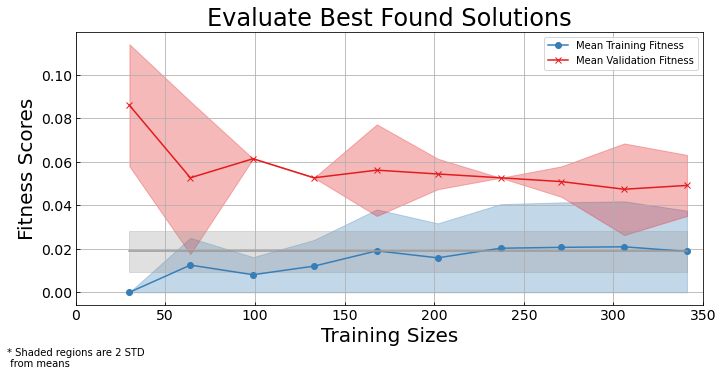

In [10]:
axs = plot_learning_curve(train_sizes, train_matrix, validation_matrix)

# Plot Expected Region during GA
ga_mean = np.repeat(best_hof_individuals[:, 2].mean(), len(train_sizes))
ga_std = np.repeat(best_hof_individuals[:, 2].std(), len(train_sizes))

alpha = 0.3

gray = "#999999"

axs.fill_between(
    train_sizes, ga_mean - 2 * ga_std, ga_mean + 2 * ga_std, alpha=alpha, color=gray
)

axs.plot(
    train_sizes,
    ga_mean,
    "-",
    color=gray,
    label="Mean GA Testing Fitness",
    linewidth=1.5,
)